In [21]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# Course Curriculum Design

We will be using skills required by data scientists and analysts from Kaggle ML and Data Science Survey, job postings on indeed, ... Will also be using learning platforms like EdX, DataCamp, ...

### Using the Kaggle ML and Data Science Survey to identify the skills

This survey contains participant's answers to the questions. In this part, we will focus on fields that identify different technical skills:
* Programming languages (Q18)
* Vizualization tools (Q20)
* ML algorithms used on regular basis (Q24)
* ML tools used on regular basis (Q25)
* Computer vision metods used (Q26)
* NLP methods used (Q27)
* ML frameworks used (Q28)
* Cloud computing platforms (Q29)
* Big data/analytics products (Q31)
* ML products used (Q32)
* Relational databases products used (Q34)

**To do**: refine the skills obtained from Kaggle Survey to better match with job requirements later (after webscraping). The skills extracted from the Kaggle dataset are too specific

In [2]:
kaggle_data = pd.read_csv('multiple_choice_responses.csv')
kaggle_data.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,83,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1


In [3]:
# Helper function to turn skills into columns and encode them
def get_skills_df(df):
    for col in df.columns.values:
        skill = df[pd.notnull(df[col])][col].unique()[0] # get the selected choice for the corresponding col
        df.loc[:, col] = df.loc[:, col].map({skill: 1})
        df.rename(columns={col:skill.lower()}, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

In [4]:
# programming languages, Q18 in the dataset (10 options)
languages = kaggle_data[['Q18_Part_1', 'Q18_Part_2', 'Q18_Part_3', 'Q18_Part_4', 'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_7', 
                       'Q18_Part_8', 'Q18_Part_9', 'Q18_Part_10']]

languages.drop([0], inplace=True)
languages.head()

,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10
1,Python,R,SQL,NaN,NaN,Java,Javascript,NaN,NaN,MATLAB
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,Bash,NaN
5,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
languages = get_skills_df(languages)
# Maybe add column for programming skills = 1 if at least one cell is 1, otherwise = 0
languages.head()

,python,r,sql,c,c++,java,javascript,typescript,bash,matlab
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
languages.sum()/len(languages)

python        0.651265
r             0.232693
sql           0.331288
c             0.084800
c++           0.114419
java          0.114977
javascript    0.110260
typescript    0.019729
bash          0.103312
matlab        0.076888
dtype: float64

In [7]:
# Get Visualization tools used: Q20
viz_tools = kaggle_data[['Q20_Part_1', 'Q20_Part_2', 'Q20_Part_3', 'Q20_Part_4', 'Q20_Part_5', 'Q20_Part_6', 'Q20_Part_7', 
                       'Q20_Part_8', 'Q20_Part_9', 'Q20_Part_10']]

viz_tools.drop([0], inplace=True)
viz_tools = get_skills_df(viz_tools)
viz_tools.head()

,ggplot / ggplot2,matplotlib,altair,shiny,d3.js,plotly / plotly express,bokeh,seaborn,geoplotlib,leaflet / folium
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [8]:
viz_tools.sum()/len(viz_tools) #Idea: For each skill with percentage < 0.1%, remove it: probably not a crucial skills

 ggplot / ggplot2            0.212101
 matplotlib                  0.533347
 altair                      0.008470
 shiny                       0.063093
 d3.js                       0.054674
 plotly / plotly express     0.163159
 bokeh                       0.052899
 seaborn                     0.350205
 geoplotlib                  0.032662
 leaflet / folium            0.027895
dtype: float64

In [9]:
# Get ML algorithms used on a regular basis: Q24
ml_algo = kaggle_data[['Q24_Part_1', 'Q24_Part_2', 'Q24_Part_3', 'Q24_Part_4', 'Q24_Part_5', 'Q24_Part_6', 'Q24_Part_7', 
                       'Q24_Part_8', 'Q24_Part_9', 'Q24_Part_10']]

ml_algo.drop([0], inplace=True)
ml_algo = get_skills_df(ml_algo)
ml_algo.head()

,linear or logistic regression,decision trees or random forests,"gradient boosting machines (xgboost, lightgbm, etc)",bayesian approaches,evolutionary approaches,"dense neural networks (mlps, etc)",convolutional neural networks,generative adversarial networks,recurrent neural networks,"transformer networks (bert, gpt-2, etc)"
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Get ML tools used on a regular basis
ml_tools = kaggle_data[['Q25_Part_1', 'Q25_Part_2', 'Q25_Part_3', 'Q25_Part_4', 'Q25_Part_5', 'Q25_Part_6']]

ml_tools.drop([0], inplace=True)
ml_tools = get_skills_df(ml_tools)
ml_tools.head()

,"automated data augmentation (e.g. imgaug, albumentations)","automated feature engineering/selection (e.g. tpot, boruta_py)","automated model selection (e.g. auto-sklearn, xcessiv)","automated model architecture searches (e.g. darts, enas)","automated hyperparameter tuning (e.g. hyperopt, ray.tune)","automation of full ml pipelines (e.g. google automl, h20 driverless ai)"
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Get Computer Vision methods used on a regular basis
computer_vision = kaggle_data[['Q26_Part_1', 'Q26_Part_2', 'Q26_Part_3', 'Q26_Part_4', 'Q26_Part_5']]

computer_vision.drop([0], inplace=True)
computer_vision = get_skills_df(computer_vision)
computer_vision.head()

,"general purpose image/video tools (pil, cv2, skimage, etc)","image segmentation methods (u-net, mask r-cnn, etc)","object detection methods (yolov3, retinanet, etc)","image classification and other general purpose networks (vgg, inception, resnet, resnext, nasnet, efficientnet, etc)","generative networks (gan, vae, etc)"
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0


In [12]:
# Get NLP methods used on a regular basis
nlp = kaggle_data[['Q27_Part_1', 'Q27_Part_2', 'Q27_Part_3', 'Q27_Part_4']]

nlp.drop([0], inplace=True)
nlp = get_skills_df(nlp)
nlp.head()

,"word embeddings/vectors (glove, fasttext, word2vec)","encoder-decorder models (seq2seq, vanilla transformers)","contextualized embeddings (elmo, cove)","transformer language models (gpt-2, bert, xlnet, etc)"
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0


In [13]:
# Get ML frameworks used: Q28
ml_frameworks = kaggle_data[['Q28_Part_1', 'Q28_Part_2', 'Q28_Part_3', 'Q28_Part_4', 'Q28_Part_5', 'Q28_Part_6', 'Q28_Part_7', 'Q28_Part_8', 'Q28_Part_9', 'Q28_Part_10']]

ml_frameworks.drop([0], inplace=True)
ml_frameworks = get_skills_df(ml_frameworks)
ml_frameworks.head()

,scikit-learn,tensorflow,keras,randomforest,xgboost,pytorch,caret,lightgbm,spark mlib,fast.ai
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
# Get cloud computing platforms used: Q29
cloud_computing = kaggle_data[['Q29_Part_1', 'Q29_Part_2', 'Q29_Part_3', 'Q29_Part_4', 'Q29_Part_5', 'Q29_Part_6',
                               'Q29_Part_7','Q29_Part_8', 'Q29_Part_9', 'Q29_Part_10']]

cloud_computing.drop([0], inplace=True)
cloud_computing = get_skills_df(cloud_computing)
cloud_computing.head(10)

,google cloud platform (gcp),amazon web services (aws),microsoft azure,ibm cloud,alibaba cloud,salesforce cloud,oracle cloud,sap cloud,vmware cloud,red hat cloud
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Get big data/ analytics products used: Q31
big_data = kaggle_data[['Q31_Part_1', 'Q31_Part_2', 'Q31_Part_3', 'Q31_Part_4', 'Q31_Part_5', 'Q31_Part_6',
                               'Q31_Part_7','Q31_Part_8', 'Q31_Part_9', 'Q31_Part_10']]

big_data.drop([0], inplace=True)
big_data = get_skills_df(big_data)
big_data.head(10)

,google bigquery,aws redshift,databricks,aws elastic mapreduce,teradata,microsoft analysis services,google cloud dataflow,aws athena,aws kinesis,google cloud pub/sub
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Get ML products used: Q32
ml_products = kaggle_data[['Q32_Part_1', 'Q32_Part_2', 'Q32_Part_3', 'Q32_Part_4', 'Q32_Part_5', 'Q32_Part_6',
                               'Q32_Part_7','Q32_Part_8', 'Q32_Part_9', 'Q32_Part_10']]

ml_products.drop([0], inplace=True)
ml_products = get_skills_df(ml_products)
ml_products.head(10)

,sas,cloudera,azure machine learning studio,google cloud machine learning engine,google cloud vision,google cloud speech-to-text,google cloud natural language,rapidminer,google cloud translation,amazon sagemaker
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Get database products used: Q34
db_products = kaggle_data[['Q34_Part_1', 'Q34_Part_2', 'Q34_Part_3', 'Q34_Part_4', 'Q34_Part_5', 'Q34_Part_6',
                               'Q34_Part_7','Q34_Part_8', 'Q34_Part_9', 'Q34_Part_10']]

db_products.drop([0], inplace=True)
db_products = get_skills_df(db_products)
db_products.head(10)

,mysql,postgressql,sqlite,microsoft sql server,oracle database,microsoft access,aws relational database service,aws dynamodb,azure sql database,google cloud sql
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Combine all the skills dataframe into one
kaggle_skills = pd.concat([languages, viz_tools, ml_algo, computer_vision, nlp, ml_frameworks, cloud_computing, 
                          big_data, ml_products, db_products], axis=1)
kaggle_skills.head(10)

,python,r,sql,c,c++,java,javascript,typescript,bash,matlab,...,mysql,postgressql,sqlite,microsoft sql server,oracle database,microsoft access,aws relational database service,aws dynamodb,azure sql database,google cloud sql
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
kaggle_skills.to_csv('./kaggle_skills.csv', index=True)

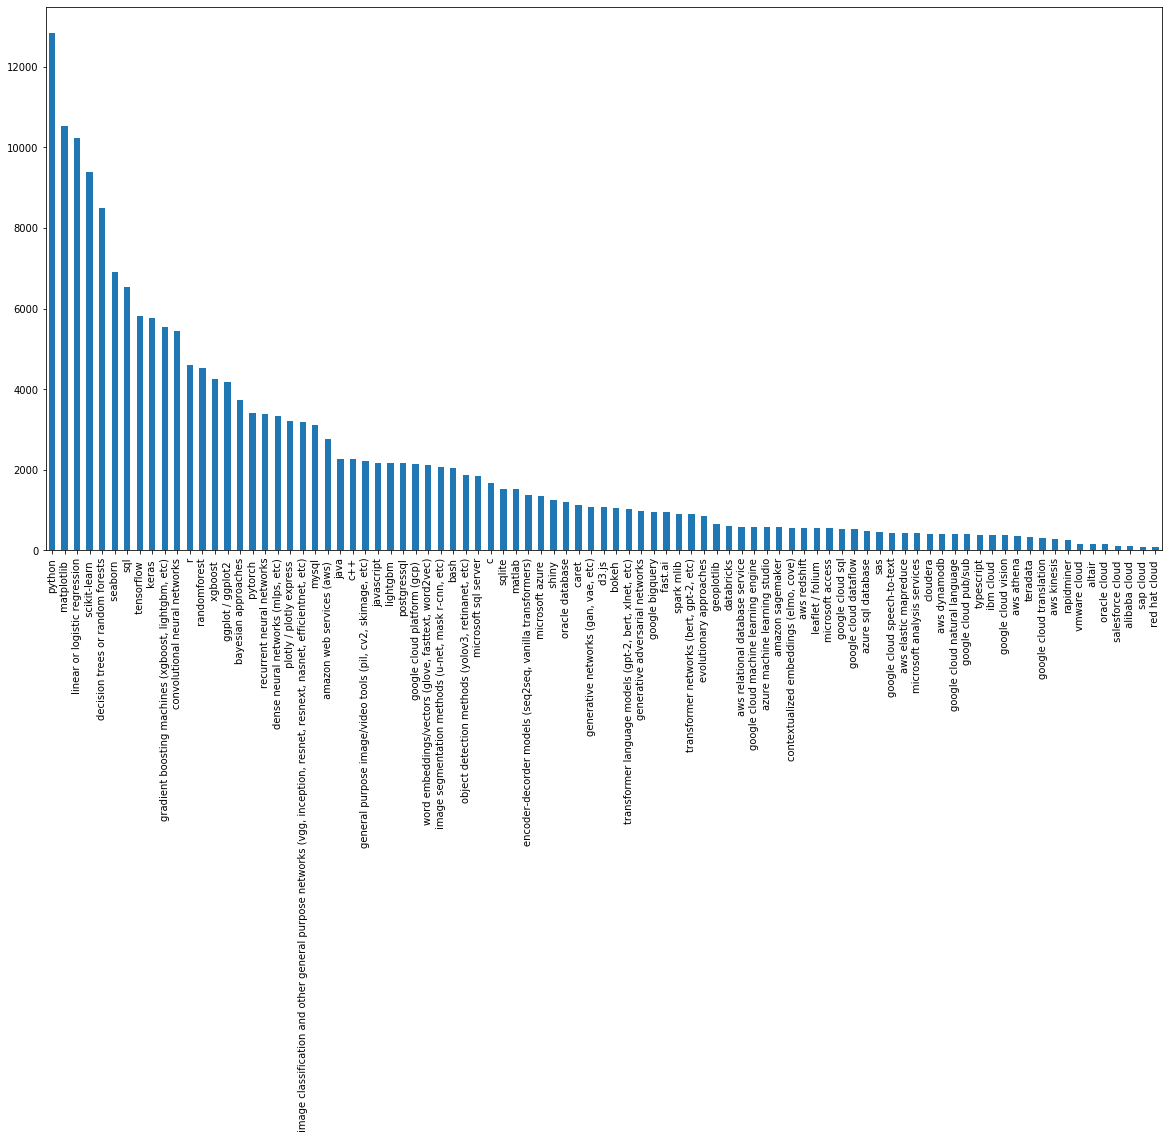

In [46]:
plt.figure(figsize=(20,10))
ax = kaggle_skills.sum().sort_values(ascending=False).plot(kind="bar")
plt.show()

### Indeed

Used the web scraping code from group 15

In this part, we want to identify which skills are required for data analysts/scientists in job postings on indeed and glassdoor.

To identify the most common skills from these job postings, we first need define which skills we'd expect to find in a data scientist/analyst. The skills extracted from the Kaggle ML and datascience survey data will be used.

In [19]:
# Scrapep indeed website, and store results in dataframe job_info
job_info = pd.DataFrame()
base = 'http://ca.indeed.com'
# Indeed displays ~10-15 jobs on each page, while each job itself can be identify as a page.
# So we search jobs every 10 pages.
# For 1000+ jobs, we need to go through 100+ pages with 10+ jobs on each page. 
import requests
pages = list(range(0,1100,10))
#pages = list(range(0,100,10))

def get_jobs():
    for page in pages:
      result = requests.get("https://ca.indeed.com/jobs?q=data+analyst%2C+data+scientist&start="+str(page)).text
      soup = BeautifulSoup(result, 'lxml')

      for jobs in soup.find_all(class_ = "result"): 

        try:
          position_title = jobs.find('a', class_='jobtitle turnstileLink').text.strip()
        except:
          position_title = None

        try:
          employer = jobs.find('span', class_='company').text.strip()
        except:
          employer = None

        try:
          location = jobs.find('span', class_='location').text.strip()
        except:
          location = None

        try:
          salary = jobs.find('span', class_ = 'salaryText').text.strip()
        except:
          salary = None

        try:
          link = base + jobs.find('a').attrs['href']
        except:
          link = None

        job_info = job_info.append({
            'position_title': position_title, 
            'employer': employer,
            'location': location,
            'salary': salary,
            'link': link}, ignore_index = True)

    #Delect dulicate jobs
    job_info = job_info.drop_duplicates(['link'], keep='first')

In [ ]:
get_jobs()

In [20]:
job_info.head()

,employer,link,location,position_title,salary
0,Syreon Corporation,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Clinical Data Manager,None
1,TekShapers,http://ca.indeed.com/company/TekShapers/jobs/D...,"Toronto, ON",Data Analyst,$45 - $55 an hour
2,"BATL, The Backyard Axe Throwing League",http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Recreation Venue General Manager,"$46,000 - $50,000 a year"
3,"BATL, The Backyard Axe Throwing League",http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Recreational Venue General Manager,"$46,000 - $50,000 a year"
4,Oxford Properties,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,BI & Data Analyst,None


In [21]:
job_info["position_title"] = job_info["position_title"].replace('', np.nan)
job_info = job_info.dropna(subset=['position_title'])
job_info.shape

(1412, 5)

In [74]:
skills = kaggle_skills.columns.values

In [75]:
#job_info.drop(skills, axis=1, inplace=True)
#job_info.head()

In [76]:

for skill in skills:
  job_info[skill] = np.zeros(len(job_info))


job_info.head()

,employer,link,location,position_title,salary,python,r,sql,c,c++,...,mysql,postgressql,sqlite,microsoft sql server,oracle database,microsoft access,aws relational database service,aws dynamodb,azure sql database,google cloud sql
0,Syreon Corporation,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Clinical Data Manager,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TekShapers,http://ca.indeed.com/company/TekShapers/jobs/D...,"Toronto, ON",Data Analyst,$45 - $55 an hour,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"BATL, The Backyard Axe Throwing League",http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Recreation Venue General Manager,"$46,000 - $50,000 a year",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"BATL, The Backyard Axe Throwing League",http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Recreational Venue General Manager,"$46,000 - $50,000 a year",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Oxford Properties,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,BI & Data Analyst,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
#job_info.reset_index(drop=True, inplace=True)
job_info.iloc[0,1] # Same as: job_info.loc[1, 'link']
job_info.loc[0, 'link']

'http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0C9jY-SedwJ7CXv8zC4Mi7jtIxglTQdXh0Kwf4f6eUh84hRmTLl4aRroG8pExlQq8nGVg3oxqELi0i_ltMj8mrJDB-n9IngOAeD_1PS2_jFhIVQQ6oYZ5SQWqSIdZbk7Ji4Jxj8bYuj-MsnlNCrSzjP5KJnwgrwruys0UC1U3pPSQBioJ376_ah3wNPmdSx6cEC4W2WKGis-Tsfgda15ldQFlImmp0XCt6zaUx-3ahRMKhZJ8ZFutWqHSlmgcCclKrCzK4Rhsi1CwrRueMu4-qhCY_eDFMeIIxKYSQCAFjy22Ek-HKTUCUIzkdalUbnV3TGIfClSlCV7ZfcmAOom98ZZpcEFU5kTUOmjuF6nU3-U0iCEQwG70rE9rYt-D2451eUuO5snJ4Ps2ImoW6Nl-wpJggJeE-6npjEHf3WWo5tGQj5wyleXireFKGyuzXxYALKeRsKsv8uEVPh02OLDF-vxsWxTHOT2XTQay1c1jf-GA==&p=0&fvj=1&vjs=3'

In [78]:
def get_job_details():
    for i in range(len(job_info)):
      link = requests.get(job_info.loc[i, 'link'])
      soup = BeautifulSoup(link.text, "lxml")
      try:
        text = soup.find('div', class_ = 'jobsearch-jobDescriptionText').text.strip().lower()
        # Preprocessing, replace punctuations, and replace multiple spaces
        text = re.sub(r'\,', ' ', text) 
        text = re.sub('/', ' ', text) 
        text = re.sub(r'\(', ' ', text) 
        text = re.sub(r'\)', ' ', text) 
        text = re.sub(' +',' ',text) 
      except:
        text = ""

      for s in skills :
        # This is specifically for C++, escape the ++. Convert C++ to C\+\+
        if any(x in s for x in ['+']):
          skill = re.escape(s)
        else:
          skill = s
        #Refine this re to m
        matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
        if matching:
          job_info[s][i] = 1
          #print("matched skill ",s, "for job ",str(i+1))

In [79]:
get_job_details()

C:\Users\merci\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
job_info.head(10)

,employer,link,location,position_title,salary,python,r,sql,c,c++,...,mysql,postgressql,sqlite,microsoft sql server,oracle database,microsoft access,aws relational database service,aws dynamodb,azure sql database,google cloud sql
0,Syreon Corporation,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Clinical Data Manager,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TekShapers,http://ca.indeed.com/company/TekShapers/jobs/D...,"Toronto, ON",Data Analyst,$45 - $55 an hour,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"BATL, The Backyard Axe Throwing League",http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Recreation Venue General Manager,"$46,000 - $50,000 a year",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"BATL, The Backyard Axe Throwing League",http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Recreational Venue General Manager,"$46,000 - $50,000 a year",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Oxford Properties,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,BI & Data Analyst,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Lixar I.T,http://ca.indeed.com/company/Lixar-I.T/jobs/Hy...,"Toronto, ON",Hybrid Data Scientist/Data Engineer,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"SOCAN - Society of Composers, Authors and Musi...",http://ca.indeed.com/rc/clk?jk=0815aa0903681b7...,"Toronto, ON",Membership - Member Services - Data Analyst,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,STONE TILE INTERNATIONAL,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Replenishment Analyst,None,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Prestige Recruiting Solutions,http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlb...,None,Contracts Manager,"$100,000 - $150,000 a year",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Miniso Canada,http://ca.indeed.com/cmp/Miniso-Canada,None,Merchandising Manager,"$60,000 - $70,000 a year",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
job_info.to_csv('./indeed_skills.csv', index=True)

In [81]:
indeed_skills = job_info.drop(['employer', 'link', 'location', 'position_title', 'salary'], axis=1)

In [43]:
indeed_skills.head()

,Python,R,SQL,C,C++,Java,Javascript,TypeScript,Bash,MATLAB,...,MySQL,PostgresSQL,SQLite,Microsoft SQL Server,Oracle Database,Microsoft Access,AWS Relational Database Service,AWS DynamoDB,Azure SQL Database,Google Cloud SQL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


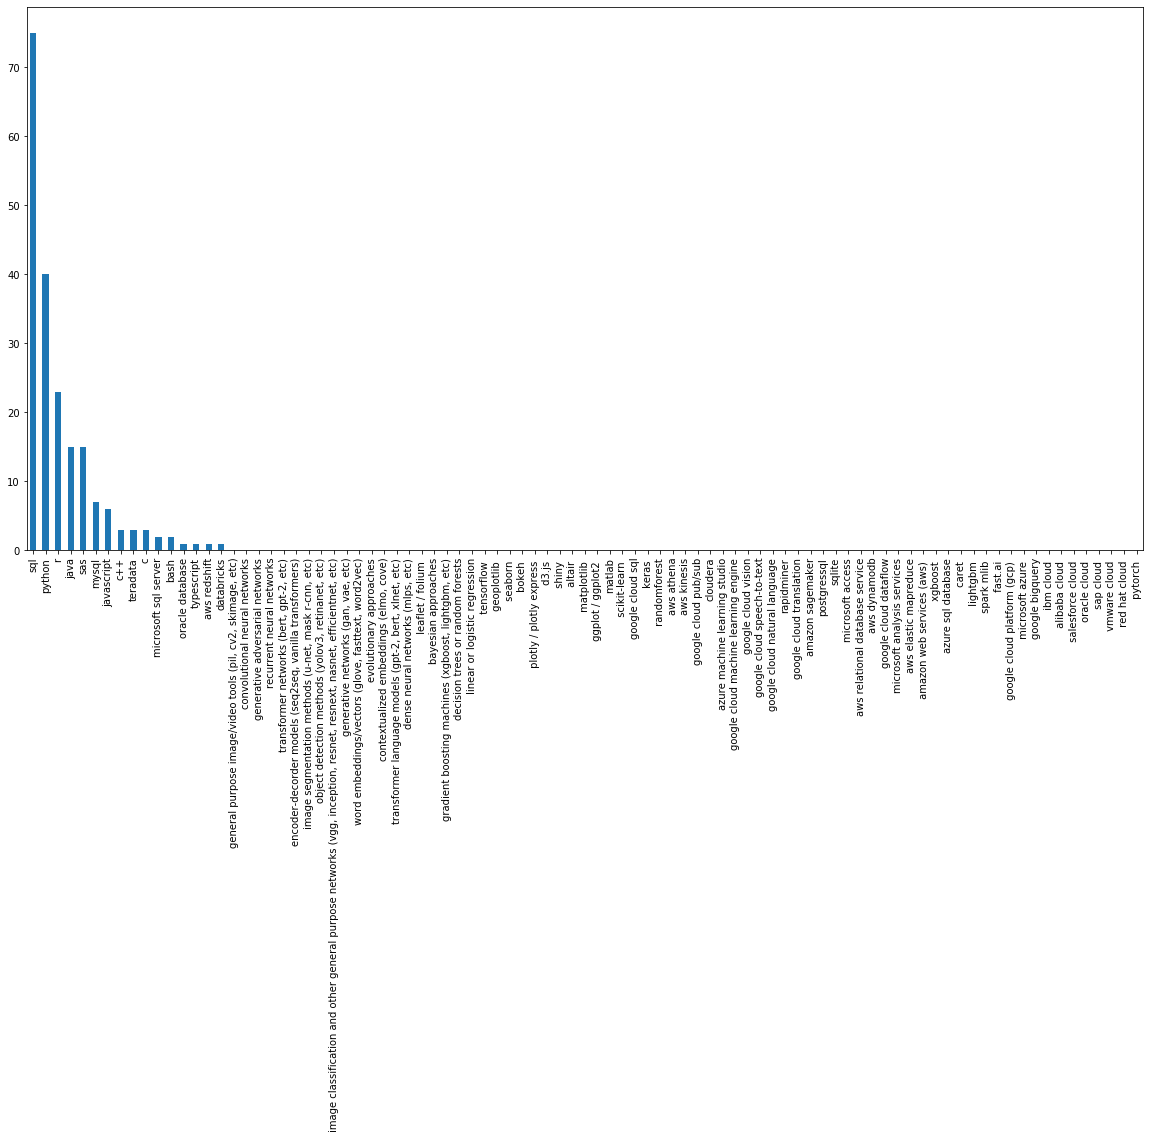

In [82]:
plt.figure(figsize=(20,10))
indeed_skills.sum().sort_values(ascending=False).plot(kind="bar")